- Pre process
- Make all sentance Equal length
- Make all articles of equal length
- Get BERT embeddings for sentances and words
- Make graph taking sentance as rows and words and label as column
- Feed in graph attention model for sentance classification

# Import Required Packages

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel


from IPython.display import clear_output # to clear the large outputs

In [2]:
# Initialize NLTK
nltk.download('punkt')
clear_output()

In [3]:
# df = pd.read_csv("../EnglishNews_train.csv", encoding="utf-8", nrows=10)
df = pd.read_csv("./newEnglishNews_train.csv", encoding="utf-8", nrows=10).dropna().reset_index().drop(['index'], axis=1)
df.head()

,Heading,Summary,Article,id
0,"Barbie Review: Greta Gerwig, Margot Robbie, Ry...",Barbie Movie Review: Ryan Gosling shines the b...,Barbie Movie Review: One mention of Barbie and...,EnglishNews_train_0
1,Gadar 2: Sunny Deol-Ameesha Patel Starrer's Tr...,A source close to the film told News18 exclusi...,"The highly anticipated Gadar 2, starring Sunny...",EnglishNews_train_1
2,Kartik Aaryan Ditches First Class To Fly In Ec...,Kartik Aaryan was spotted flying in economy cl...,"Kartik Aaryan, who is gearing up for the relea...",EnglishNews_train_2
3,"India's Anju, Now Fatima, Receives Land, Money...",Abbasi had said that it was important to make ...,"Indian woman, Anju who travelled to Pakistan t...",EnglishNews_train_3
4,Himachal Pradesh Hotels Offer 50% Discount As ...,Flash floods and landslides caused by heavy do...,"Himachal Pradesh, one of the worst hit states ...",EnglishNews_train_4


In [4]:
df.shape

(10, 4)

# Preprocess and word tokenize all articles

In [5]:
articles = df["Article"]
article = articles[0]
article

'Barbie Movie Review: One mention of Barbie and you instantly think of a lean, tall-figured doll who is always well-dressed and has a perfect life. This stereotype is stuck with the doll for years, despite the numerous new designs and models being introduced. Director Greta Gerwig understood these stereotypes and even plays along with them for the first 15 to 20 minutes of the Barbie movie. However, she shatters the glass as soon as she is done playing with the &amp;#8216;doll&amp;#8217; and gets down to business to tell a relatable, feminist, and applaud-worthy movie that lives up to the hype.Barbie, starring Margot Robbie in the lead, is set in Barbie Land which has several kinds of Barbies co-existing. We see the stereotype Barbie (Margot), the President Barbie (Issa Rae), Physicist Barbie (Emma Mackey), and Lawyer Barbie (Sharon Rooney), among many more, running the Barbie land while the men, all of them named Ken, double up as their supporters, lovers, and partners.All goes well i

In [6]:
all_summary = df["Summary"]
summary = all_summary[0]
summary

'Barbie Movie Review: Ryan Gosling shines the brightest in the Greta Gerwig film. Margot Robbie proves she was meant for this role.'

In [7]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
clear_output()

# Preprocess the text
def preprocess(text):
    text = ' '.join(nltk.word_tokenize(text))
    
    # Lowercase
    text = text.lower()

    # Replace the newlines and punctuations with space
    filters = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    text = text.translate(str.maketrans(filters, ' '*len(filters)))

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # Remove punctuations and numbers
    text = ' '.join([word for word in text.split() if word.isalpha()])
    
    # Remove single character
    text = ' '.join([word for word in text.split() if len(word) > 2])
    return text

In [8]:
def word_tokenize_articles(articles):
    preprocessed_articles = []
    word_tokenized_articles_list = []
    for article in articles:
        sentences = nltk.sent_tokenize(article)
        preprocessed_sentences = [preprocess(sentence) for sentence in sentences]

        # Word tokenization after preprocessing
        word_tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in preprocessed_sentences]
        word_tokenized_articles_list.append(word_tokenized_sentences)
        preprocessed_articles.append(preprocessed_sentences)
    
    return word_tokenized_articles_list

In [9]:
word_tokenized_articles = word_tokenize_articles(articles)
print("Preprocessed and word tokenized article: ", word_tokenized_articles[0])

Preprocessed and word tokenized article:  [['barbie', 'movie', 'review', 'one', 'mention', 'barbie', 'instantly', 'think', 'lean', 'tall', 'figured', 'doll', 'always', 'well', 'dressed', 'perfect', 'life'], ['stereotype', 'stuck', 'doll', 'years', 'despite', 'numerous', 'new', 'designs', 'models', 'introduced'], ['director', 'greta', 'gerwig', 'understood', 'stereotypes', 'even', 'plays', 'along', 'first', 'minutes', 'barbie', 'movie'], ['however', 'shatters', 'glass', 'soon', 'done', 'playing', 'amp', 'doll', 'amp', 'gets', 'business', 'tell', 'relatable', 'feminist', 'applaud', 'worthy', 'movie', 'lives', 'hype', 'barbie', 'starring', 'margot', 'robbie', 'lead', 'set', 'barbie', 'land', 'several', 'kinds', 'barbies', 'existing'], ['see', 'stereotype', 'barbie', 'margot', 'president', 'barbie', 'issa', 'rae', 'physicist', 'barbie', 'emma', 'mackey', 'lawyer', 'barbie', 'sharon', 'rooney', 'among', 'many', 'running', 'barbie', 'land', 'men', 'named', 'ken', 'double', 'supporters', 'lov

# Generate BERT embeddings for setances and words

## Make TF-IDF functions

In [10]:
# Get IDF from here and make tf for each sentence while making bert embeddings
def get_idf(word_tokenized_article):
    words_frequency = {}                    # Number of times a word appears in the document
    total_sentences_containing_word = {}    # Number of sentences containing a word
    words_idf = {}                          # IDF of each word

    for sentence in word_tokenized_article:
        for word in sentence:
            if word not in words_frequency.keys():
                words_frequency[word] = 1
            else:
                words_frequency[word] += 1
        
        for word in set(sentence):
            if word not in total_sentences_containing_word.keys():
                total_sentences_containing_word[word] = 1
            else:
                total_sentences_containing_word[word] += 1


    for word in words_frequency.keys():
        words_idf[word] = np.log(len(word_tokenized_article) / words_frequency[word])

    return words_frequency, words_idf


## Generate sentance and word embedding for each article

In [11]:
# Get word embeddings for all the words
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)
clear_output()

In [12]:
# Load already saved embeddings if available
import os
if os.path.exists("./word_embeddings.npy"):
    all_word_embeddings = np.load("./word_embeddings.npy", allow_pickle=True).item()
else:
    all_word_embeddings = {}

In [13]:
# Get a common word embeddings for all the words in all the documents
def get_word_embeddings(word_tokenized_articles):
    # Get all the words in all the articles
    all_words = []
    for article in word_tokenized_articles:
        for sentence in article:
            for word in sentence:
                all_words.append(word)
    
    # Get unique words
    unique_words = list(set(all_words))
    print("Number of unique words: ", len(unique_words))

    embedding = {}
    for word in unique_words:
        if word in all_word_embeddings.keys():
            embedding[word] = all_word_embeddings[word]
            continue
        encoded_input = tokenizer(word, return_tensors='tf')
        output = model(encoded_input)
        all_word_embeddings[word] = output[0][0][0].numpy()
        embedding[word] = output[0][0][0].numpy()

    return embedding


In [14]:
all_articles_word_embeddings = get_word_embeddings(word_tokenized_articles)
np.save("./word_embeddings.npy", all_word_embeddings)

Number of unique words:  1521


In [15]:
# Define a BERT model and tokenizer (replace with the specific BERT model you are using)
model_name = "bert-base-uncased"  # Example: You can use a different pretrained model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)
clear_output()

In [16]:
def get_embeddings(word_tokenize_article):
    # Initialize lists to store sentence and word embeddings
    sentence_embeddings = []
    word_embeddings = []

    # Store the tokenized input IDs, attention masks and token type IDs
    input_ids = []
    attention_masks = []


    for sentence in word_tokenize_article:
        # Convert words to BERT tokens
        tokens = [tokenizer.cls_token] + sentence + [tokenizer.sep_token]

        # Convert tokens to input IDs
        _input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # Create attention masks by tf-idf values (freq of word in sentence / total sentences containing word)
        words_frequency, words_idf = get_idf(word_tokenize_article)

        words_tf = {}
        for word in sentence:
            if word not in words_tf.keys():
                words_tf[word] = 1
            else:
                words_tf[word] += 1
        
        attention_mask = [0] + [words_tf[word]/words_frequency[word] * words_idf[word] for word in sentence] + [0]


        # Create an input dictionary in the expected format
        input_dict = {
            'input_ids': tf.constant([_input_ids]),
            'attention_mask': tf.constant([attention_mask]),
        }

        # Get BERT model output
        with tf.device('/GPU:0'):
            output = model(input_dict)

        # Extract sentence and word embeddings
        sentence_embedding = tf.reduce_mean(output.last_hidden_state, axis=1).numpy()  # Sentence embedding
        word_embedding = output.last_hidden_state.numpy()  # Word embeddings

        # Append to lists
        sentence_embeddings.append(sentence_embedding.reshape(768, ))
        # word_embeddings.append(word_embedding.reshape(-1, 768))

        # Append to lists Attention masks and input IDs
        input_ids.append(tf.constant([_input_ids]).numpy().reshape(-1))
        attention_masks.append(tf.constant([attention_mask]).numpy().reshape(-1))

    return sentence_embeddings

In [17]:
# Store the sentence and word embeddings for each article 
all_articles_sentence_embeddings = []
for article in word_tokenized_articles:
    sentence_embedding = get_embeddings(article)
    all_articles_sentence_embeddings.append(sentence_embedding)

# Make all articles of equal length

In [18]:
max_article_len = 0

for article in word_tokenized_articles:
    max_article_len = max(max_article_len, len(article))

In [19]:
padded_articles = []

# Padding and truncating the articles
for article in word_tokenized_articles:
    while len(article) < max_article_len:
        article.append([])
    while len(article) > max_article_len:
        article.pop()
    padded_articles.append(article)

print("Padded and truncated article: ", padded_articles[0])

Padded and truncated article:  [['barbie', 'movie', 'review', 'one', 'mention', 'barbie', 'instantly', 'think', 'lean', 'tall', 'figured', 'doll', 'always', 'well', 'dressed', 'perfect', 'life'], ['stereotype', 'stuck', 'doll', 'years', 'despite', 'numerous', 'new', 'designs', 'models', 'introduced'], ['director', 'greta', 'gerwig', 'understood', 'stereotypes', 'even', 'plays', 'along', 'first', 'minutes', 'barbie', 'movie'], ['however', 'shatters', 'glass', 'soon', 'done', 'playing', 'amp', 'doll', 'amp', 'gets', 'business', 'tell', 'relatable', 'feminist', 'applaud', 'worthy', 'movie', 'lives', 'hype', 'barbie', 'starring', 'margot', 'robbie', 'lead', 'set', 'barbie', 'land', 'several', 'kinds', 'barbies', 'existing'], ['see', 'stereotype', 'barbie', 'margot', 'president', 'barbie', 'issa', 'rae', 'physicist', 'barbie', 'emma', 'mackey', 'lawyer', 'barbie', 'sharon', 'rooney', 'among', 'many', 'running', 'barbie', 'land', 'men', 'named', 'ken', 'double', 'supporters', 'lovers', 'part

In [20]:
# Also make the sentance embeddings equal to the max_article_len
padded_articles_sentence_embeddings = []

for article in all_articles_sentence_embeddings:
    while len(article) < max_article_len:
        article = np.concatenate((article, np.zeros((1, 768))), axis=0)
    while len(article) > max_article_len:
        article = article[:-1]
    padded_articles_sentence_embeddings.append(article)

len(padded_articles_sentence_embeddings)

10

# Create a adjecency matrix for each article


For each article need to make a s*w matrix

- w:= Unique words in the whole dataset
- s:- Number of sentances in each article

In [21]:
all_unique_words = set()
for article in padded_articles:
    for sentence in article:
        for word in sentence:
            all_unique_words.add(word)

all_unique_words = list(all_unique_words)

In [22]:
print("All unique words size: ", len(all_unique_words))
print("Length of each articles: ", len(padded_articles[0]))
print("Matrix size: ", len(padded_articles), len(padded_articles[0]), len(all_unique_words))

All unique words size:  1521
Length of each articles:  31
Matrix size:  10 31 1521


In [23]:
# For each article create a (s+w)*(s+w) matrix where s is the number of sentences and w is the number of unique words
# and the value of each cell is the tf-idf value of the word in the sentence, sentence in the sentence and word in the word are zero

all_articles_adjacency_matrices = []
for article in padded_articles:
    article_adjacency_matrix = []
    words_frequency, words_idf = get_idf(article)
    for sentence in article:
        # GET TF-IDF VALUES OF WORDS IN THE SENTENCE
        words_tf = {}
        for word in sentence:
            if word not in words_tf.keys():
                words_tf[word] = 1
            else:
                words_tf[word] += 1
        words_tf_idf = {}
        for word in words_tf.keys():
            words_tf_idf[word] = words_tf[word]/words_frequency[word] * words_idf[word]

        # CREATE ADJACENCY MATRIX
        sentence_adjacency_matrix = []
        for _ in range(len(article)):
            sentence_adjacency_matrix.append(0)
        
        for word in all_unique_words:
            if word in sentence:
                sentence_adjacency_matrix.append(words_tf_idf[word])
            else:
                sentence_adjacency_matrix.append(0)
        article_adjacency_matrix.append(sentence_adjacency_matrix)

    for _ in range(len(all_unique_words)):
        article_adjacency_matrix.append([0]*(len(article)+len(all_unique_words)))
    all_articles_adjacency_matrices.append(article_adjacency_matrix)

print("Adjacency matrix size: ", len(all_articles_adjacency_matrices), len(all_articles_adjacency_matrices[0]), len(all_articles_adjacency_matrices[0][0]))


Adjacency matrix size:  10 1552 1552


In [24]:
# check how many non zero values are there in the first article
count = 0
for i in range(len(all_articles_adjacency_matrices[0])):
    for j in range(len(all_articles_adjacency_matrices[0][i])):
        if all_articles_adjacency_matrices[0][i][j] != 0:
            count += 1
print("Number of non zero values in the first article: ", count)

Number of non zero values in the first article:  431


## Create Graph for each article:-
- Node Features
- Edges

In [25]:
# Sentances numbers are from 0 to all the sentances in the article
# Words numbers are from #number of sentance to all the unique words in all the articles
# So the total number of nodes are the number of sentances + number of unique words

# From the adjecency matrix create a list of edges with the weights
all_articles_edges = []
for article in all_articles_adjacency_matrices:
    article_edges = []
    for i in range(len(article)):
        for j in range(len(article[i])):
            if article[i][j] != 0:
                article_edges.append((i, j, article[i][j]))
    all_articles_edges.append(article_edges)

In [26]:
len(all_articles_edges[0])

431

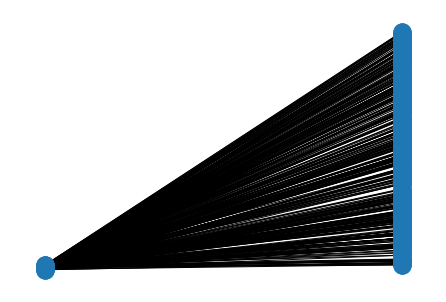

In [36]:
# Create a graph for first article edges
import networkx as nx
import matplotlib.pyplot as plt

# Plot as a bipartite graph with sentances and words
G = nx.Graph()
G.add_weighted_edges_from(all_articles_edges[0])
# G.add_weighted_edges_from(all_articles_edges[0][:30])
# One side for up to max_article_len nodes and the other side for the rest
pos = {}
for i in range(len(padded_articles[0])):
    pos[i] = (0, i)

for i in range(len(padded_articles[0]), len(all_articles_adjacency_matrices[0])):
    pos[i] = (1, i)

nx.draw(G, pos, with_labels=False, font_weight='bold')
plt.show()

# Auto endcoder model

- Node Features = [Sentance Embeddings, Word Embeddings]
- Edges = [edges between sentace and word node]

In [37]:
from tensorflow.keras import layers, models

class GraphAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GraphAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[-1], self.output_dim),
                                      initializer='glorot_uniform',
                                      trainable=True)
        super(GraphAttentionLayer, self).build(input_shape)

    def call(self, x, adj_matrix):
        h = tf.matmul(x, self.kernel)
        # print(h.shape)
        attn_coef = tf.matmul(tf.matmul(h, adj_matrix), h, transpose_b=True)
        attn_coef = tf.nn.leaky_relu(attn_coef, alpha=0.2)
        attn_coef = tf.nn.softmax(attn_coef, axis=-1)
        output = tf.matmul(attn_coef, h)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

# Create a Keras Graph model with Graph Attention Layer
class GraphAutoencoderWithAttention(tf.keras.Model):
    def __init__(self, input_size, hidden_size):
        super(GraphAutoencoderWithAttention, self).__init__()

        # Graph Attention Layer
        self.attention = GraphAttentionLayer(output_dim=hidden_size)

        # Decoder
        self.decoder = layers.Dense(input_size, activation='sigmoid')
        # self.decoder = layers.Dense(1, activation='softmax')

    def call(self, inputs, adj_matrix, training=None, mask=None):
        x = self.attention(inputs, adj_matrix)
        x = self.decoder(x)
        return x


In [38]:
# Instantiate the model
input_size = 768  # Size of node features
hidden_size = max_article_len + len(all_unique_words)  # Hidden dimension size for attention layer
model = GraphAutoencoderWithAttention(input_size, hidden_size)

# Define the loss function and optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

## Train the model

In [39]:
# Create node features from the sentence embeddings for each article
all_articles_node_features = []
for article in padded_articles_sentence_embeddings:
    article_node_features = []
    for sentence in article:
        article_node_features.append(sentence)
    for word in all_unique_words:
        article_node_features.append(all_articles_word_embeddings[word])
    all_articles_node_features.append(article_node_features)

# Convert to tensor node_features_tensor,adjacency_matrix_tensor
# node_features_tensor = tf.constant(all_articles_node_features)
# adjacency_matrix_tensor = tf.constant(all_articles_adjacency_matrices)

In [74]:
# # Train test split node features tensor and adjacency matrix tensor
# from sklearn.model_selection import train_test_split
# node_features_train, node_features_test, adjacency_matrix_train, adjacency_matrix_test = train_test_split(all_articles_node_features, all_articles_adjacency_matrices, test_size=0.2, random_state=42)
# len(adjacency_matrix_train), len(adjacency_matrix_train[0]), len(adjacency_matrix_train[0][1500])

In [75]:
# Train test split node features tensor and adjacency matrix tensor first by index and then by value
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(range(len(all_articles_node_features)), range(len(all_articles_adjacency_matrices)), test_size=0.2, random_state=42)


In [76]:
node_features_train = []
node_features_test = []
adjacency_matrix_train = []
adjacency_matrix_test = []

for i in x_train:
    node_features_train.append(all_articles_node_features[i])

for i in y_train:
    adjacency_matrix_train.append(all_articles_adjacency_matrices[i])

for i in x_test:
    node_features_test.append(all_articles_node_features[i])

for i in y_test:
    adjacency_matrix_test.append(all_articles_adjacency_matrices[i])

len(adjacency_matrix_train), len(adjacency_matrix_train[0]), len(adjacency_matrix_train[0][1500])

(8, 1552, 1552)

In [77]:
# Convert to tensor node_features_tensor,adjacency_matrix_tensor
node_features_train_tensor = tf.constant(node_features_train)
node_features_test_tensor = tf.constant(node_features_test)

adjacency_matrix_train_tensor = tf.constant(adjacency_matrix_train)
adjacency_matrix_test_tensor = tf.constant(adjacency_matrix_test)

In [78]:
node_features_train_tensor.shape, adjacency_matrix_train_tensor.shape

(TensorShape([8, 1552, 768]), TensorShape([8, 1552, 1552]))

In [79]:

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    # For each node features and adjacency matrix pair
    for node_features, adjacency_matrix in zip(node_features_train_tensor, adjacency_matrix_train_tensor):
        # print(node_features_tensor.shape, adjacency_matrix_tensor.shape)
        with tf.GradientTape() as tape:
            reconstructed_features = model(node_features,adjacency_matrix)
            loss = loss_fn(node_features, reconstructed_features)

    # update the weights after each epoch for the whole dataset
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.numpy():.4f}')



Epoch 1/100, Loss: 0.1929
Epoch 11/100, Loss: 0.1929
Epoch 21/100, Loss: 0.1929
Epoch 31/100, Loss: 0.1929
Epoch 41/100, Loss: 0.1929
Epoch 51/100, Loss: 0.1929
Epoch 61/100, Loss: 0.1929
Epoch 71/100, Loss: 0.1929
Epoch 81/100, Loss: 0.1929
Epoch 91/100, Loss: 0.1929


# Testing

In [80]:
## Generate new embeddings for the test data

In [81]:
# After training, you can use the learned embeddings for downstream tasks
node_features = np.array(all_articles_node_features[0], dtype=np.float32)
adjacency_matrix = np.array(all_articles_adjacency_matrices[0], dtype=np.float32)
node_features_tensor = tf.constant(node_features)
adjacency_matrix_tensor = tf.constant(adjacency_matrix)
learned_embeddings = model(node_features_tensor, adjacency_matrix_tensor).numpy()
# print(learned_embeddings)

In [82]:
test_articles_predicted_embeddings = []
for node_features, adjacency_matrix in zip(node_features_test_tensor, adjacency_matrix_test_tensor):
    reconstructed_features = model(node_features,adjacency_matrix)
    test_articles_predicted_embeddings.append(reconstructed_features)

In [83]:
len(test_articles_predicted_embeddings), test_articles_predicted_embeddings[0].shape

(2, TensorShape([1552, 768]))

In [84]:
test_sentance_predecited_embeddings = [article[:max_article_len] for article in test_articles_predicted_embeddings]
test_sentance_predecited_embeddings[0].shape

TensorShape([31, 768])

In [86]:
# test_articles_predicted_embeddings

# Sentance Selection

## Use Page Rank

In [87]:
# for i in test_articles_predicted_embeddings[0]:
#     print(i)

In [88]:
from sklearn.metrics.pairwise import cosine_similarity

def page_rank(article_predicted_embeddings):
    '''
    Apply page rank on these embeddings of dimesion (max_article_len, 768)
    Get the top 15% sentences
    Return the summary
    '''
    
    # Calculate cosine similarity matrix
    cosine_similarity_matrix = cosine_similarity(article_predicted_embeddings)
    # print(cosine_similarity_matrix)
    # distances = 1 - cosine_similarity_matrix
    distances = np.round(cosine_similarity_matrix.clip(min=0), 2)
    # print(distances)
    # print(distances.shape)

    # Adjecency list calucate
    m = [[] for _ in range(len(distances))]
    for i in range(len(distances)):
        for j in range(len(distances[i])):
            if distances[i][j] >= 0.95:
                m[i].append(j)

    # Page rank calculation using custom furmula
    n = len(m)
    d, it = .85, 1000
    rank = [1 for _ in range(n)]

    # Calculate rank for each iteration
    for _ in range(it):
        for i in range(n):
            rank[i] = (1-d) + d * sum([rank[x]/len(m[x]) for x in m[i]])
    
    # print(rank)

    # Get the top 15% sentences with the highest rank and return them as a list of sentences index
    top_15_percent = int(max_article_len * 0.15)
    top_15_percent_sentences = []
    for i in range(top_15_percent):
        top_15_percent_sentences.append(rank.index(max(rank)))
        rank[rank.index(max(rank))] = 0

    return top_15_percent_sentences

In [89]:
a = list(test_articles_predicted_embeddings[0].numpy())
a.extend(list(test_articles_predicted_embeddings[1].numpy()))
len(a)

3104

In [90]:
page_rank(test_articles_predicted_embeddings[0][:max_article_len])

[6, 13, 15, 16]

In [91]:
page_ranked_index_for_each_test_article = []

for article in test_articles_predicted_embeddings:
    page_ranked_index_for_each_test_article.append(page_rank(article[:max_article_len]))


## Generate new summary

In [94]:
x_test, y_test

([8, 1], [8, 1])

In [99]:
all_articles_new_summary = []

for i in range(len(page_ranked_index_for_each_test_article)):
    article_number = x_test[i]
    sentence_tokaniized_article = nltk.sent_tokenize(articles[article_number])
    summary = ""
    for index in page_ranked_index_for_each_test_article[i]:
        if index < len(sentence_tokaniized_article):
            summary += sentence_tokaniized_article[index] + " "
    all_articles_new_summary.append(summary)

# Calculate rouge score

In [104]:
from rouge import Rouge
rouge = Rouge()

def similarity_using_rouge(sentance1, sentance2):
    rouge_scores = rouge.get_scores(sentance1, sentance2)[0]
    rouge_1 = rouge_scores['rouge-1']
    rouge_2 = rouge_scores['rouge-2']
    rouge_l = rouge_scores['rouge-l']
    return rouge_1, rouge_2, rouge_l

In [105]:
rouge_df = pd.DataFrame(columns=['rouge-1 r', 'rouge-1 p', 'rouge-1 f', 'rouge-2 r', 'rouge-2 p', 'rouge-2 f', 'rouge-l r', 'rouge-l p', 'rouge-l f'])


In [106]:
rouge_1_r, rouge_1_p, rouge_1_f = 0, 0, 0
rouge_2_r, rouge_2_p, rouge_2_f = 0, 0, 0
rouge_l_r, rouge_l_p, rouge_l_f = 0, 0, 0


for i in range(len(all_articles_new_summary)):
    rouge_1, rouge_2, rouge_l = similarity_using_rouge(all_articles_new_summary[i], all_summary[y_test[i]])
    rouge_1_r += rouge_1['r'] / len(y_test)
    rouge_1_p += rouge_1['p'] / len(y_test)
    rouge_1_f += rouge_1['f'] / len(y_test)
    rouge_2_r += rouge_2['r'] / len(y_test)
    rouge_2_p += rouge_2['p'] / len(y_test)
    rouge_2_f += rouge_2['f'] / len(y_test)
    rouge_l_r += rouge_l['r'] / len(y_test)
    rouge_l_p += rouge_l['p'] / len(y_test)
    rouge_l_f += rouge_l['f'] / len(y_test)


In [107]:
print("Rouge scores: ")
print("Rouge-1: ")
print(f"r: {rouge_1_r}\np: {rouge_1_p}\nf: {rouge_1_f}\n")
print("Rouge-2: ")
print(f"r: {rouge_2_r}\np: {rouge_2_p}\nf: {rouge_2_f}\n")
print("Rouge-l: ")
print(f"r: {rouge_l_r}\np: {rouge_l_p}\nf: {rouge_l_f}\n")

Rouge scores: 
Rouge-1: 
r: 0.6029411764705882
p: 0.23426573426573427
f: 0.3085592404695935

Rouge-2: 
r: 0.5
p: 0.1
f: 0.16666666527777782

Rouge-l: 
r: 0.5735294117647058
p: 0.20396270396270394
f: 0.2787084942009368



In [108]:

rouge_df = rouge_df.append({'rouge-1 r': rouge_1_r, 'rouge-1 p': rouge_1_p, 'rouge-1 f': rouge_1_f, 'rouge-2 r': rouge_2_r, 'rouge-2 p': rouge_2_p, 'rouge-2 f': rouge_2_f, 'rouge-l r': rouge_l_r, 'rouge-l p': rouge_l_p, 'rouge-l f': rouge_l_f}, ignore_index=True)


C:\Users\PULKIT\AppData\Local\Temp\ipykernel_328\655384883.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rouge_df = rouge_df.append({'rouge-1 r': rouge_1_r, 'rouge-1 p': rouge_1_p, 'rouge-1 f': rouge_1_f, 'rouge-2 r': rouge_2_r, 'rouge-2 p': rouge_2_p, 'rouge-2 f': rouge_2_f, 'rouge-l r': rouge_l_r, 'rouge-l p': rouge_l_p, 'rouge-l f': rouge_l_f}, ignore_index=True)


In [109]:
rouge_df.to_csv("./rouge_scores.csv", index=False)